# BraTS 2025 Task 2 Label

Using device: cuda


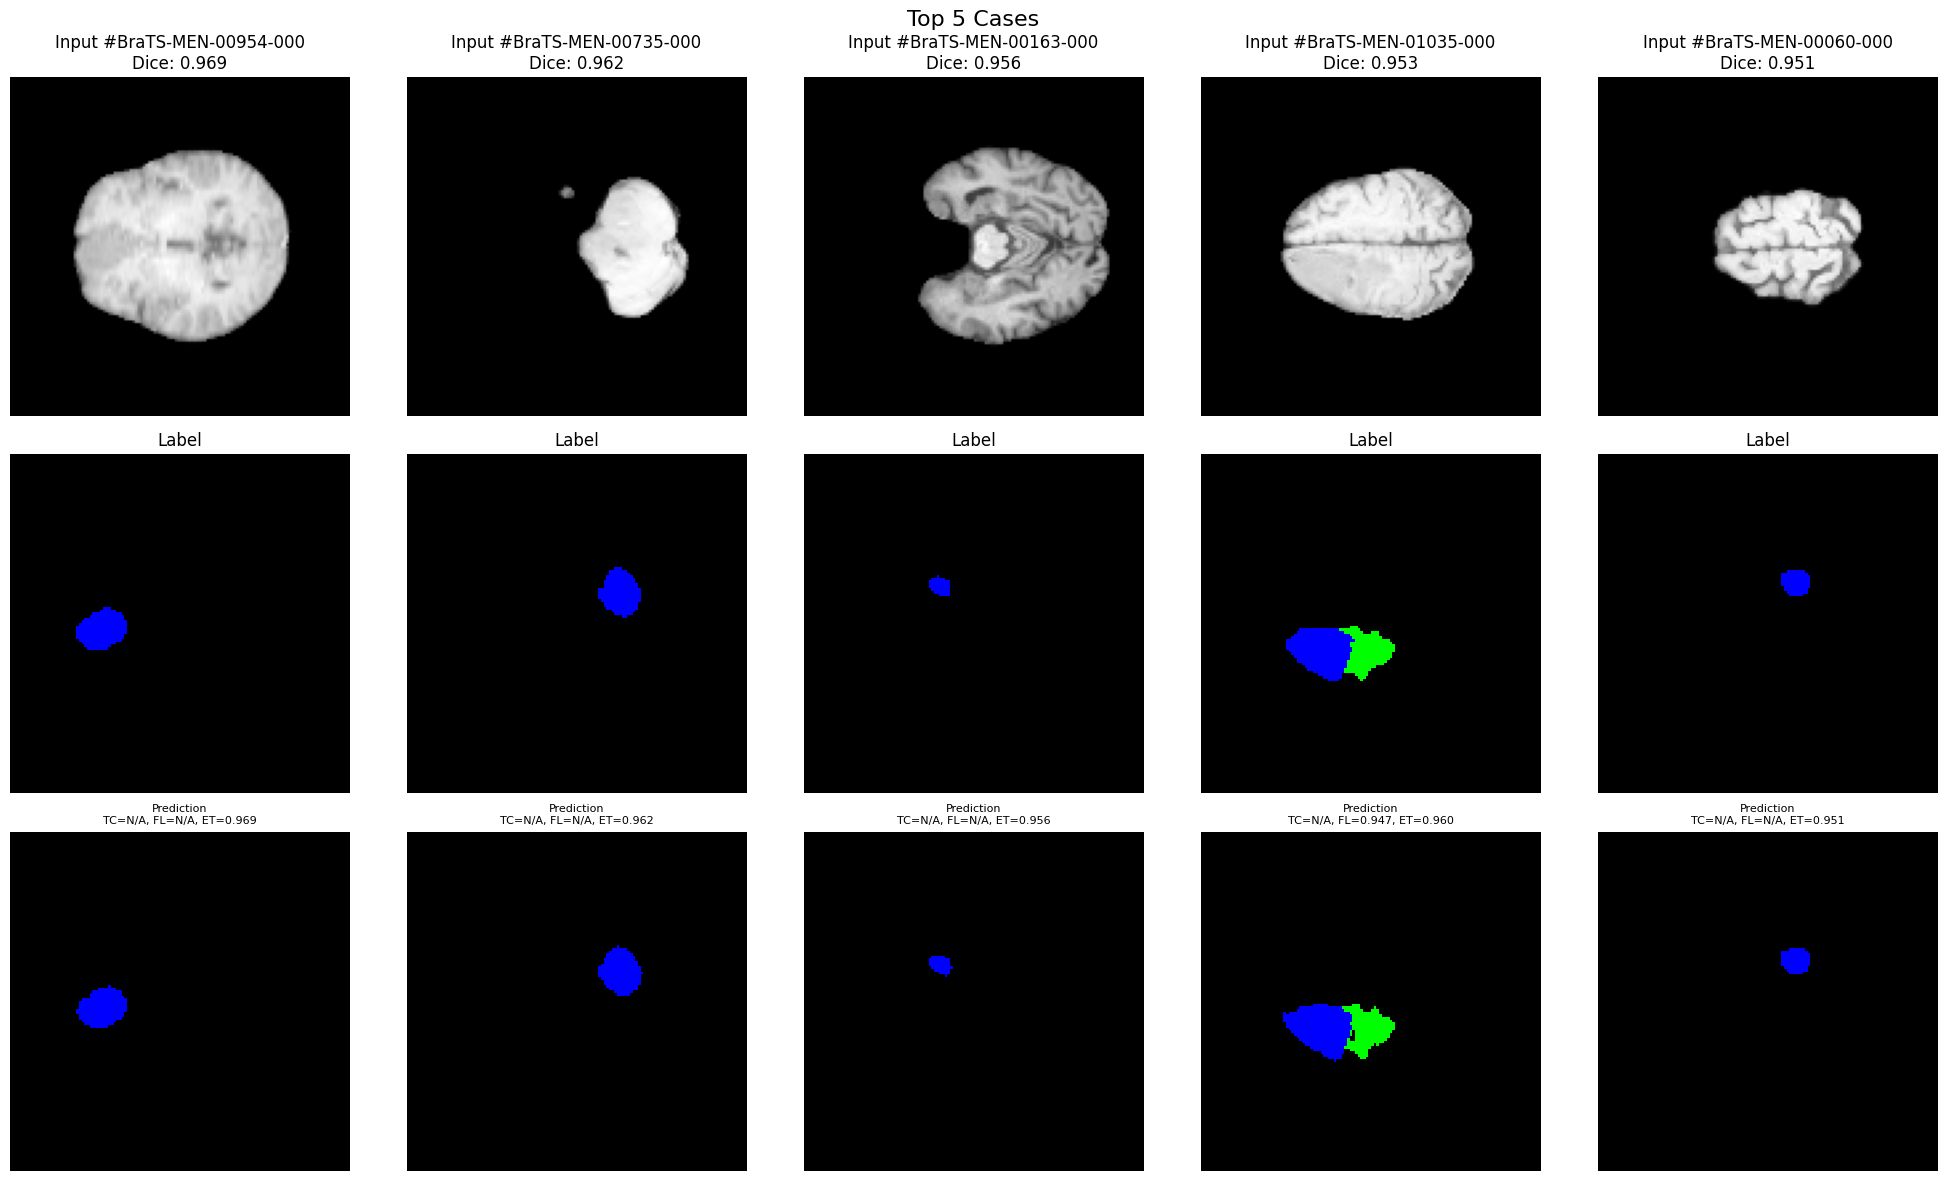

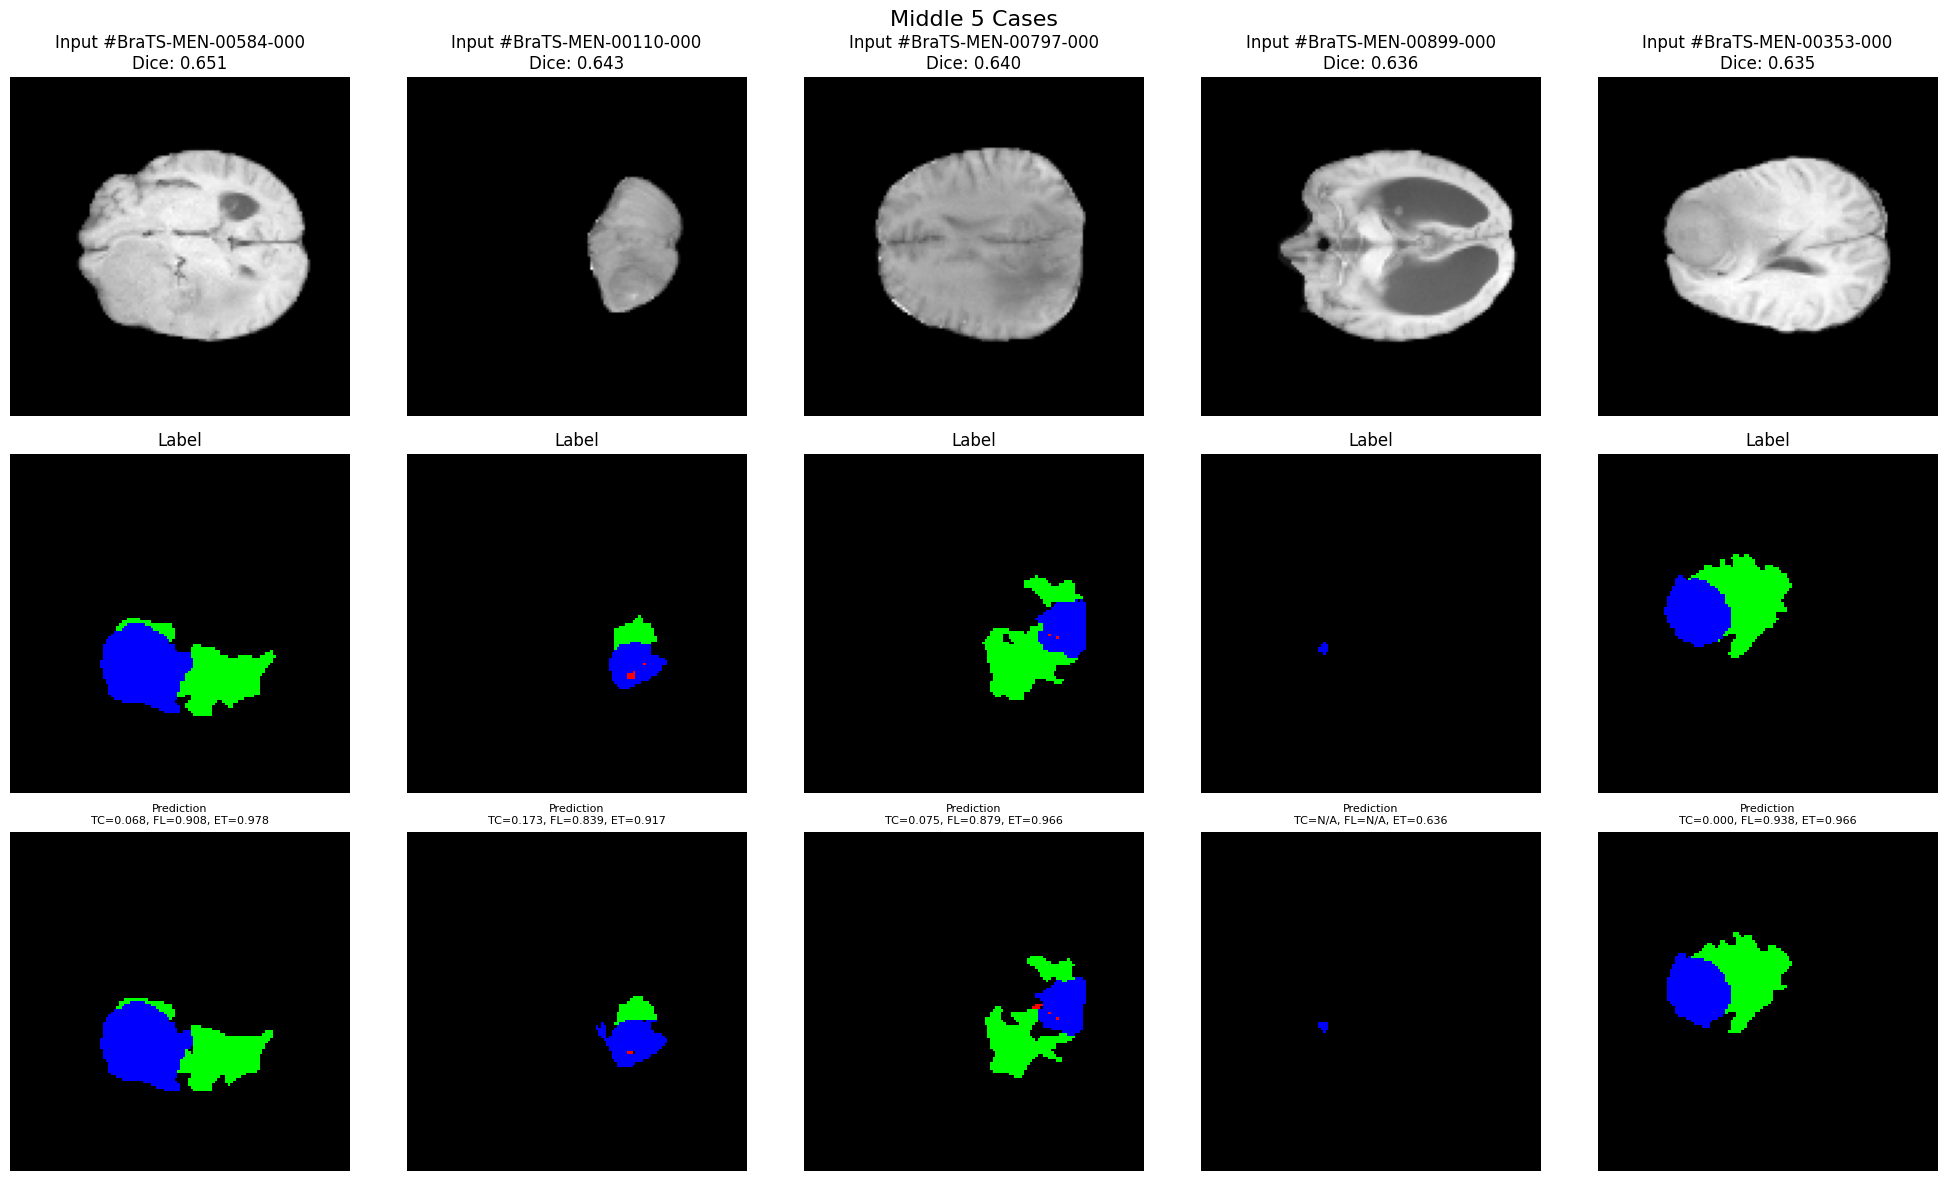

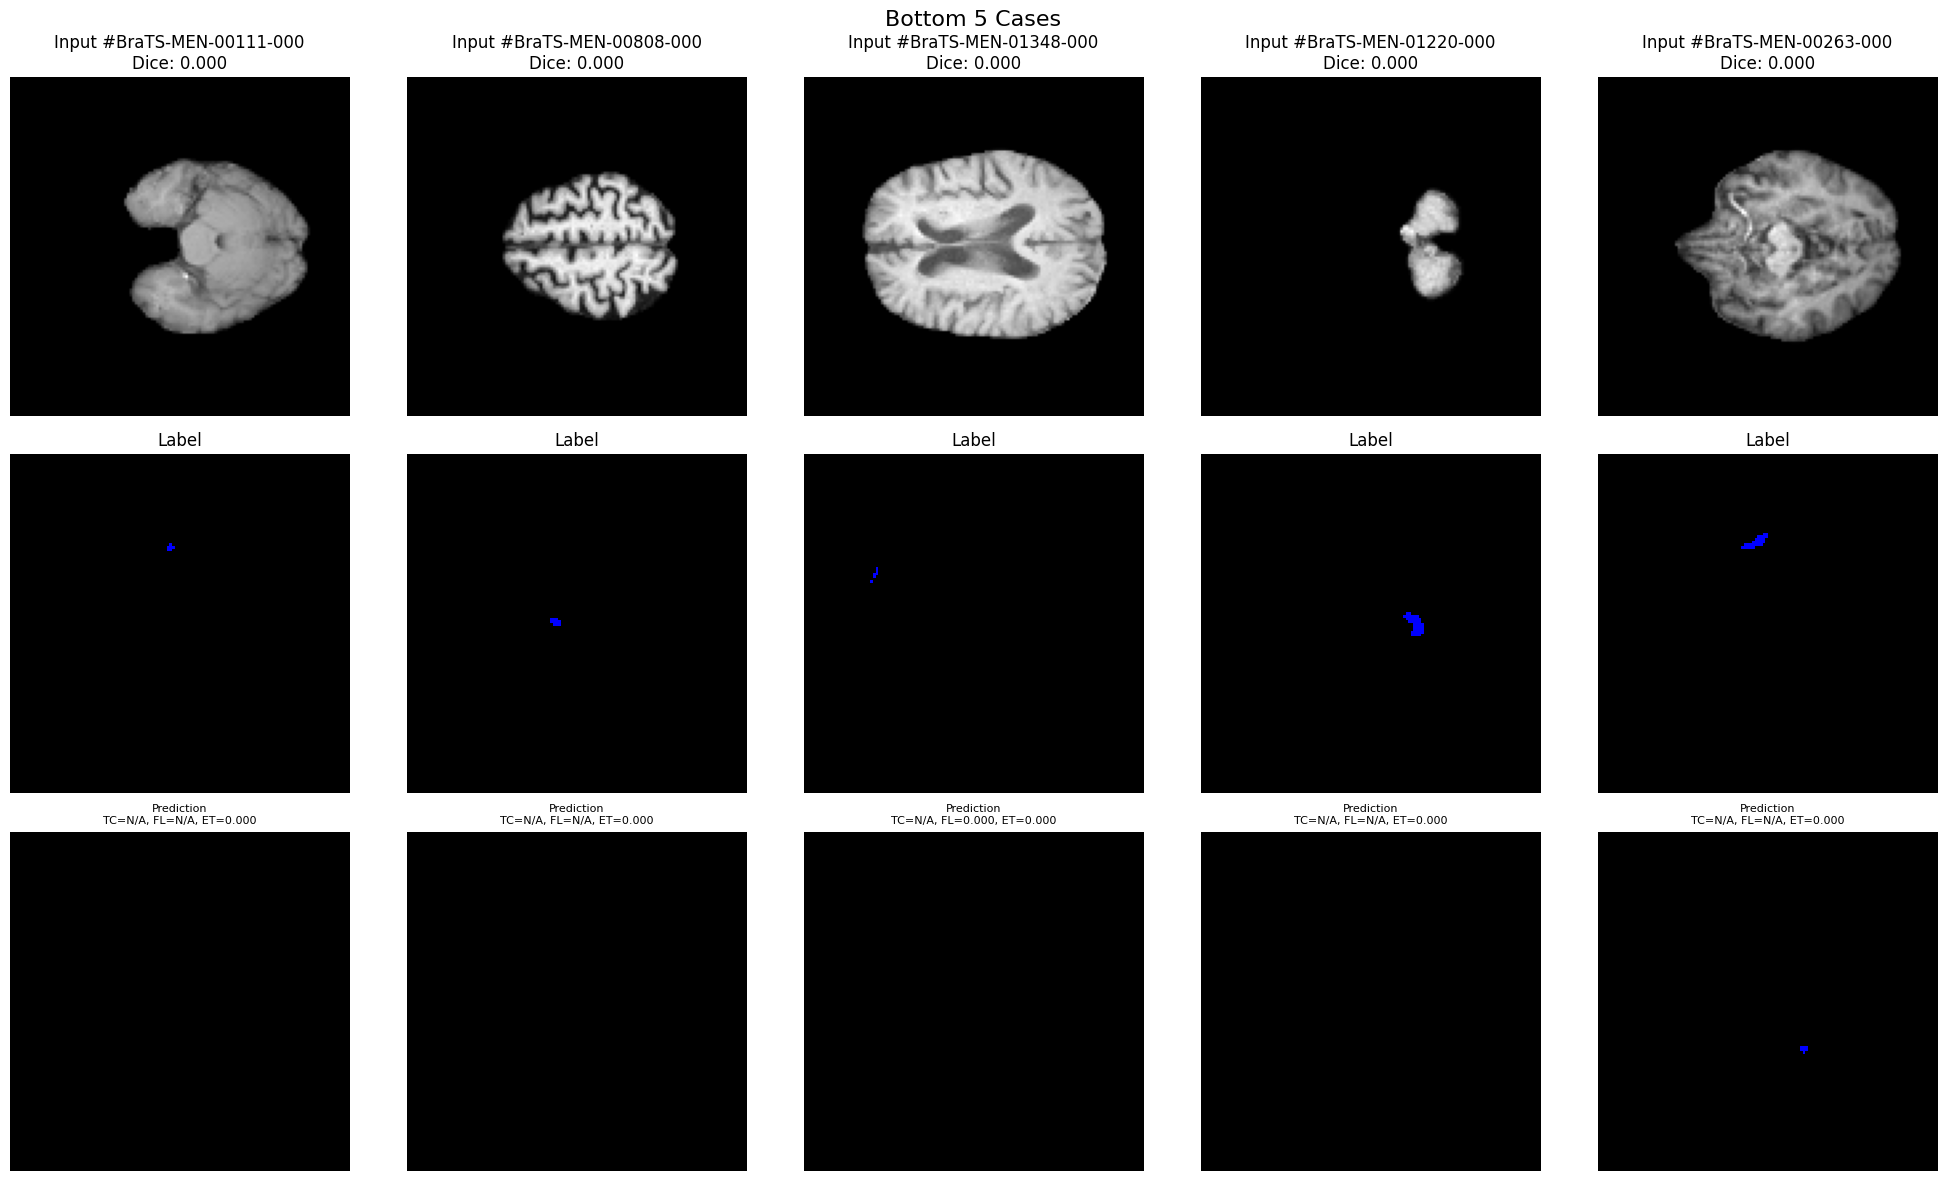

Mean Dice - TC: 0.2187, FLAIR: 0.5058, ET: 0.8456
Mean Dice (Overall Average): 0.6402


In [ ]:
# =======================================
# 1. Import
# =======================================
import os, json, math
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from monai.networks.nets import SwinUNETR

device = "cuda" if torch.cuda.is_available() else "cpu"
TARGET_SIZE = (128, 128, 128)
print("Using device:", device)

# =======================================
# 2. Utils
# =======================================
def normalize_minmax(arr, eps=1e-8):
    return (arr - arr.min()) / (arr.max() - arr.min() + eps)

def resize_3d_numpy_to_torch(arr, is_label):
    t = torch.from_numpy(arr).unsqueeze(0).unsqueeze(0).float()
    if is_label:
        t = F.interpolate(t, size=TARGET_SIZE, mode="nearest")
    else:
        t = F.interpolate(t, size=TARGET_SIZE, mode="trilinear", align_corners=False)
    return t.squeeze().cpu().numpy()

def dice_per_class(pred, gt, n_class=4, eps=1e-7):
    dices = []
    for c in range(1, n_class):
        pred_c = (pred == c).astype(np.uint8)
        gt_c   = (gt   == c).astype(np.uint8)
        if np.sum(gt_c) + np.sum(pred_c) == 0:
            dice = np.nan
        else:
            inter = np.sum(pred_c * gt_c)
            dice = (2 * inter + eps) / (np.sum(gt_c) + np.sum(pred_c) + eps)
        dices.append(dice)
    return dices

# =======================================
# 3. Fusion Head (학습과 동일)
# =======================================
class Fusion1x1(nn.Module):
    def __init__(self, in_ch=3, out_ch=4):
        super().__init__()
        self.head = nn.Conv3d(in_ch, out_ch, kernel_size=1)
    def forward(self, x):
        return self.head(x)

class FusionSmall(nn.Module):
    def __init__(self, in_ch=3, out_ch=4, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_ch, hidden, 3, padding=1),
            nn.InstanceNorm3d(hidden), nn.ReLU(inplace=True),
            nn.Conv3d(hidden, hidden, 3, padding=1),
            nn.InstanceNorm3d(hidden), nn.ReLU(inplace=True),
            nn.Conv3d(hidden, out_ch, 1)
        )
    def forward(self, x):
        return self.net(x)

# =======================================
# 4. Base SwinUNETR Loader
# =======================================
def build_swinunetr(in_channels=4):
    return SwinUNETR(
        img_size=TARGET_SIZE,
        in_channels=in_channels,
        out_channels=1,
        feature_size=48,
        use_checkpoint=True,
    )

def load_base(ckpt):
    net = build_swinunetr(4).to(device)
    sd  = torch.load(ckpt, map_location=device)
    net.load_state_dict(sd)
    net.eval()
    for p in net.parameters():
        p.requires_grad = False
    return net

# =======================================
# 5. Inference (Fusion CNN)
# =======================================
@torch.no_grad()
def inference_fusion(imgs_t, gt, net_et, net_tc, net_flair, fusion):
    logit_et    = net_et(imgs_t)   
    logit_tc    = net_tc(imgs_t)   
    logit_flair = net_flair(imgs_t)

    feats   = torch.cat([logit_et, logit_tc, logit_flair], dim=1)  
    logits4 = fusion(feats)                                    
    pred    = torch.argmax(F.softmax(logits4, dim=1), dim=1).squeeze(0).cpu().numpy().astype(np.uint8)

    dice_tc, dice_flair, dice_et = dice_per_class(pred, gt)
    dice_avg = np.nanmean([dice_tc, dice_flair, dice_et])
    return pred, dice_tc, dice_flair, dice_et, dice_avg

# =======================================
# 6. Case Loader
# =======================================
def load_case(case, root_dir):
    imgs = []
    for rel_path in case["image"]:
        arr = nib.load(os.path.join(root_dir, rel_path)).get_fdata().astype(np.float32)
        arr = normalize_minmax(arr)
        arr = resize_3d_numpy_to_torch(arr, False)
        imgs.append(arr)
    imgs = np.stack(imgs, 0).astype(np.float32)        
    imgs_t = torch.from_numpy(imgs).unsqueeze(0).to(device)

    gt_arr   = nib.load(os.path.join(root_dir, case["label"])).get_fdata().astype(np.uint8)
    gt_arr_rs = resize_3d_numpy_to_torch(gt_arr, True).astype(np.uint8)
    return imgs, imgs_t, gt_arr_rs

# =======================================
# 7. Visualization
# =======================================
cmap = mcolors.ListedColormap([
    (0,0,0,1),   # 0 background
    (1,0,0,1),   # 1 TC (red)
    (0,1,0,1),   # 2 FLAIR (green)
    (0,0,1,1)    # 3 ET (blue)
])
norm = mcolors.BoundaryNorm([0,1,2,3,4], cmap.N)

def show_case(imgs, gt, pred, dices, case_name, slice_idx, title_prefix="Fusion CNN"):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"{title_prefix}\nCase: {case_name}, Slice={slice_idx}", fontsize=14)

    axes[0].imshow(imgs[2, :, :, slice_idx], cmap="gray")
    axes[0].set_title("Input (T2)")
    axes[0].axis("off")

    axes[1].imshow(gt[:, :, slice_idx].astype(np.uint8), cmap=cmap, norm=norm, interpolation="nearest")
    axes[1].set_title("GT")
    axes[1].axis("off")

    dice_tc, dice_fl, dice_et, dice_avg = dices
    def fmt(x): return "N/A" if np.isnan(x) else f"{x:.3f}"

    axes[2].imshow(pred[:, :, slice_idx].astype(np.uint8), cmap=cmap, norm=norm, interpolation="nearest")
    axes[2].set_title(f"{title_prefix}\nAvg={fmt(dice_avg)}\nTC={fmt(dice_tc)}, FL={fmt(dice_fl)}, ET={fmt(dice_et)}", fontsize=10)
    axes[2].axis("off")
    plt.tight_layout()
    plt.show()

# =======================================
# 8. Run Evaluation (Top/Mid/Bottom)
# =======================================
root_dir  = "C:/Users/admin/Documents/AIM_LAB/BraTS2025/BraTS-MEN-Train"
json_path = "C:/Users/admin/Documents/AIM_LAB/test_data.json"

# 베이스 모델 ckpt (학습 때 사용한 것과 동일!)
ckpt_et    = "C:/Users/admin/Documents/AIM_LAB/output_et_1/swinunetr_et.pt"
ckpt_tc    = "C:/Users/admin/Documents/AIM_LAB/output_tc_1/swinunetr_tc.pt"
ckpt_flair = "C:/Users/admin/Documents/AIM_LAB/output_flair_1/swinunetr_flair.pt"

net_et    = load_base(ckpt_et)
net_tc    = load_base(ckpt_tc)
net_flair = load_base(ckpt_flair)

# Fusion head load (학습 시 설정과 동일해야 함)
USE_SMALL = False
fusion_ckpt = "C:/Users/admin/Documents/AIM_LAB/Best_Fusion.pth"
fusion = (FusionSmall(3, 4, 16) if USE_SMALL else Fusion1x1(3, 4)).to(device)
fusion.load_state_dict(torch.load(fusion_ckpt, map_location=device))
fusion.eval()

# Load test data
with open(json_path) as f:
    test_data = json.load(f)["test"]

results = []
for case in test_data:
    imgs, imgs_t, gt = load_case(case, root_dir)
    pred, tc, fl, et, avg = inference_fusion(imgs_t, gt, net_et, net_tc, net_flair, fusion)
    results.append((case["label"], pred, (tc, fl, et, avg), imgs, gt))

def safe_key_avg(x):
    val = x[2][3]
    return -1 if np.isnan(val) else val

results_sorted = sorted(results, key=lambda x: safe_key_avg(x), reverse=True)

N = len(results_sorted)
top5 = results_sorted[:5]
mid5 = results_sorted[max(0, N//2 - 2): min(N, N//2 + 3)]
bot5 = results_sorted[-5:]

# =============================
# 그룹 시각화
# =============================
def show_group(group, group_name):
    n = len(group)
    if n == 0:
        print(group_name, "비어있음")
        return
    fig, axes = plt.subplots(3, n, figsize=(4*n, 12))
    fig.suptitle(f"{group_name} Cases", fontsize=16)

    if n == 1:
        axes = np.array([[axes[0]], [axes[1]], [axes[2]]])

    for i, (label_path, pred, dices, imgs, gt) in enumerate(group):
        slice_idx = int(np.argmax(gt.sum(axis=(0, 1))))
        dice_tc, dice_fl, dice_et, dice_avg = dices
        def fmt(x): return "N/A" if np.isnan(x) else f"{x:.3f}"

        axes[0, i].imshow(imgs[2, :, :, slice_idx], cmap="gray")
        axes[0, i].set_title(f"Input #{os.path.basename(os.path.dirname(label_path))}\nDice: {fmt(dice_avg)}")
        axes[0, i].axis("off")

        axes[1, i].imshow(gt[:, :, slice_idx].astype(np.uint8), cmap=cmap, norm=norm, interpolation="nearest")
        axes[1, i].set_title("Label")
        axes[1, i].axis("off")

        axes[2, i].imshow(pred[:, :, slice_idx].astype(np.uint8), cmap=cmap, norm=norm, interpolation="nearest")
        axes[2, i].set_title(f"Prediction\nTC={fmt(dice_tc)}, FL={fmt(dice_fl)}, ET={fmt(dice_et)}", fontsize=8)
        axes[2, i].axis("off")

    plt.tight_layout()
    plt.show()

# 실행
show_group(top5,  "Top 5")
show_group(mid5,  "Middle 5")
show_group(bot5,  "Bottom 5")

# =======================================
# 9. Mean Dice
# =======================================
def safe_mean(values):
    valid = [v for v in values if not math.isnan(v)]
    return sum(valid) / len(valid) if valid else float("nan")

mean_tc    = safe_mean([x[2][0] for x in results])  # TC
mean_flair = safe_mean([x[2][1] for x in results])  # FLAIR
mean_et    = safe_mean([x[2][2] for x in results])  # ET
mean_all   = safe_mean([x[2][3] for x in results])  # 평균 Dice

print(f"Mean Dice - TC: {mean_tc:.4f}, FLAIR: {mean_flair:.4f}, ET: {mean_et:.4f}")
print(f"Mean Dice (Overall Average): {mean_all:.4f}")

# BraTS 2021 Label

Using device: cuda


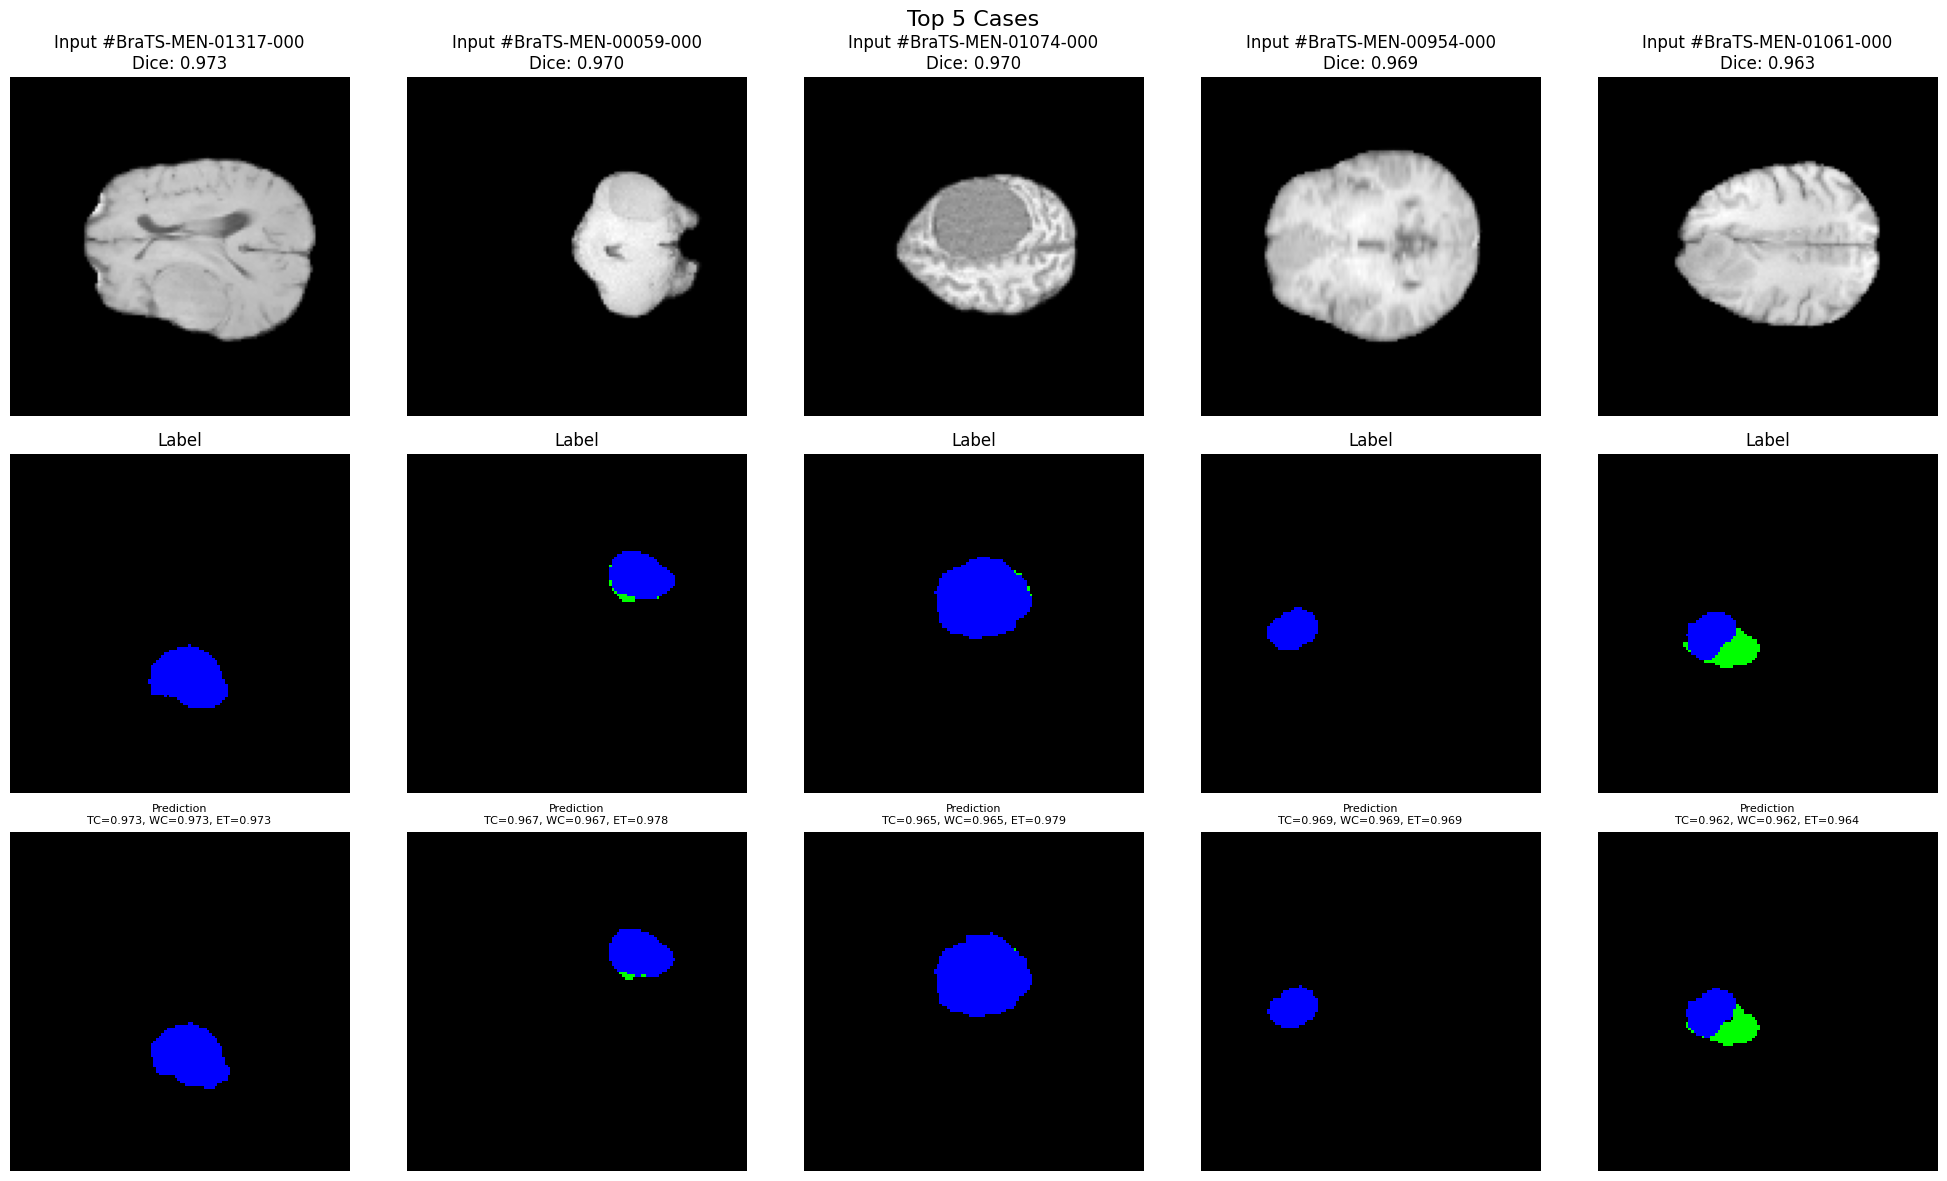

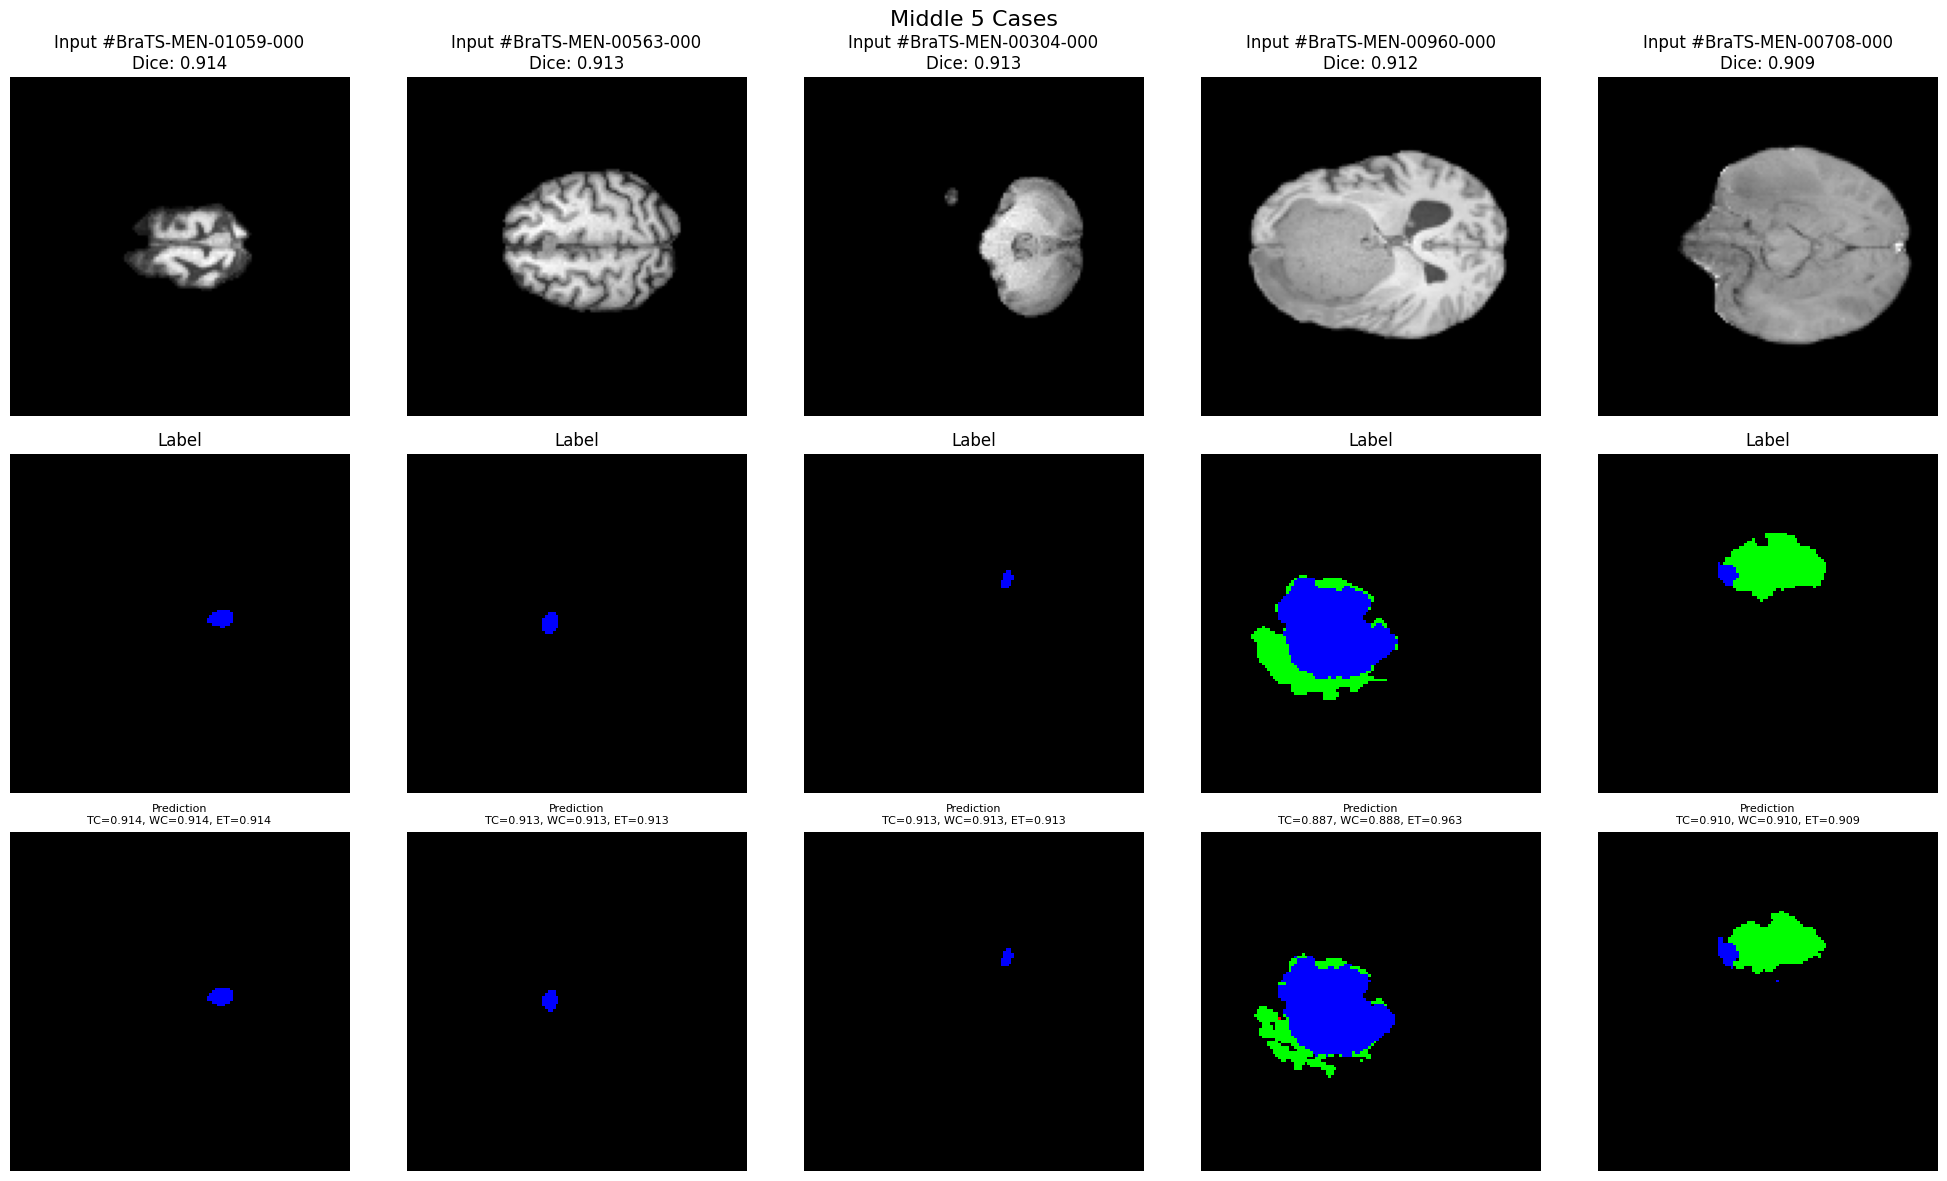

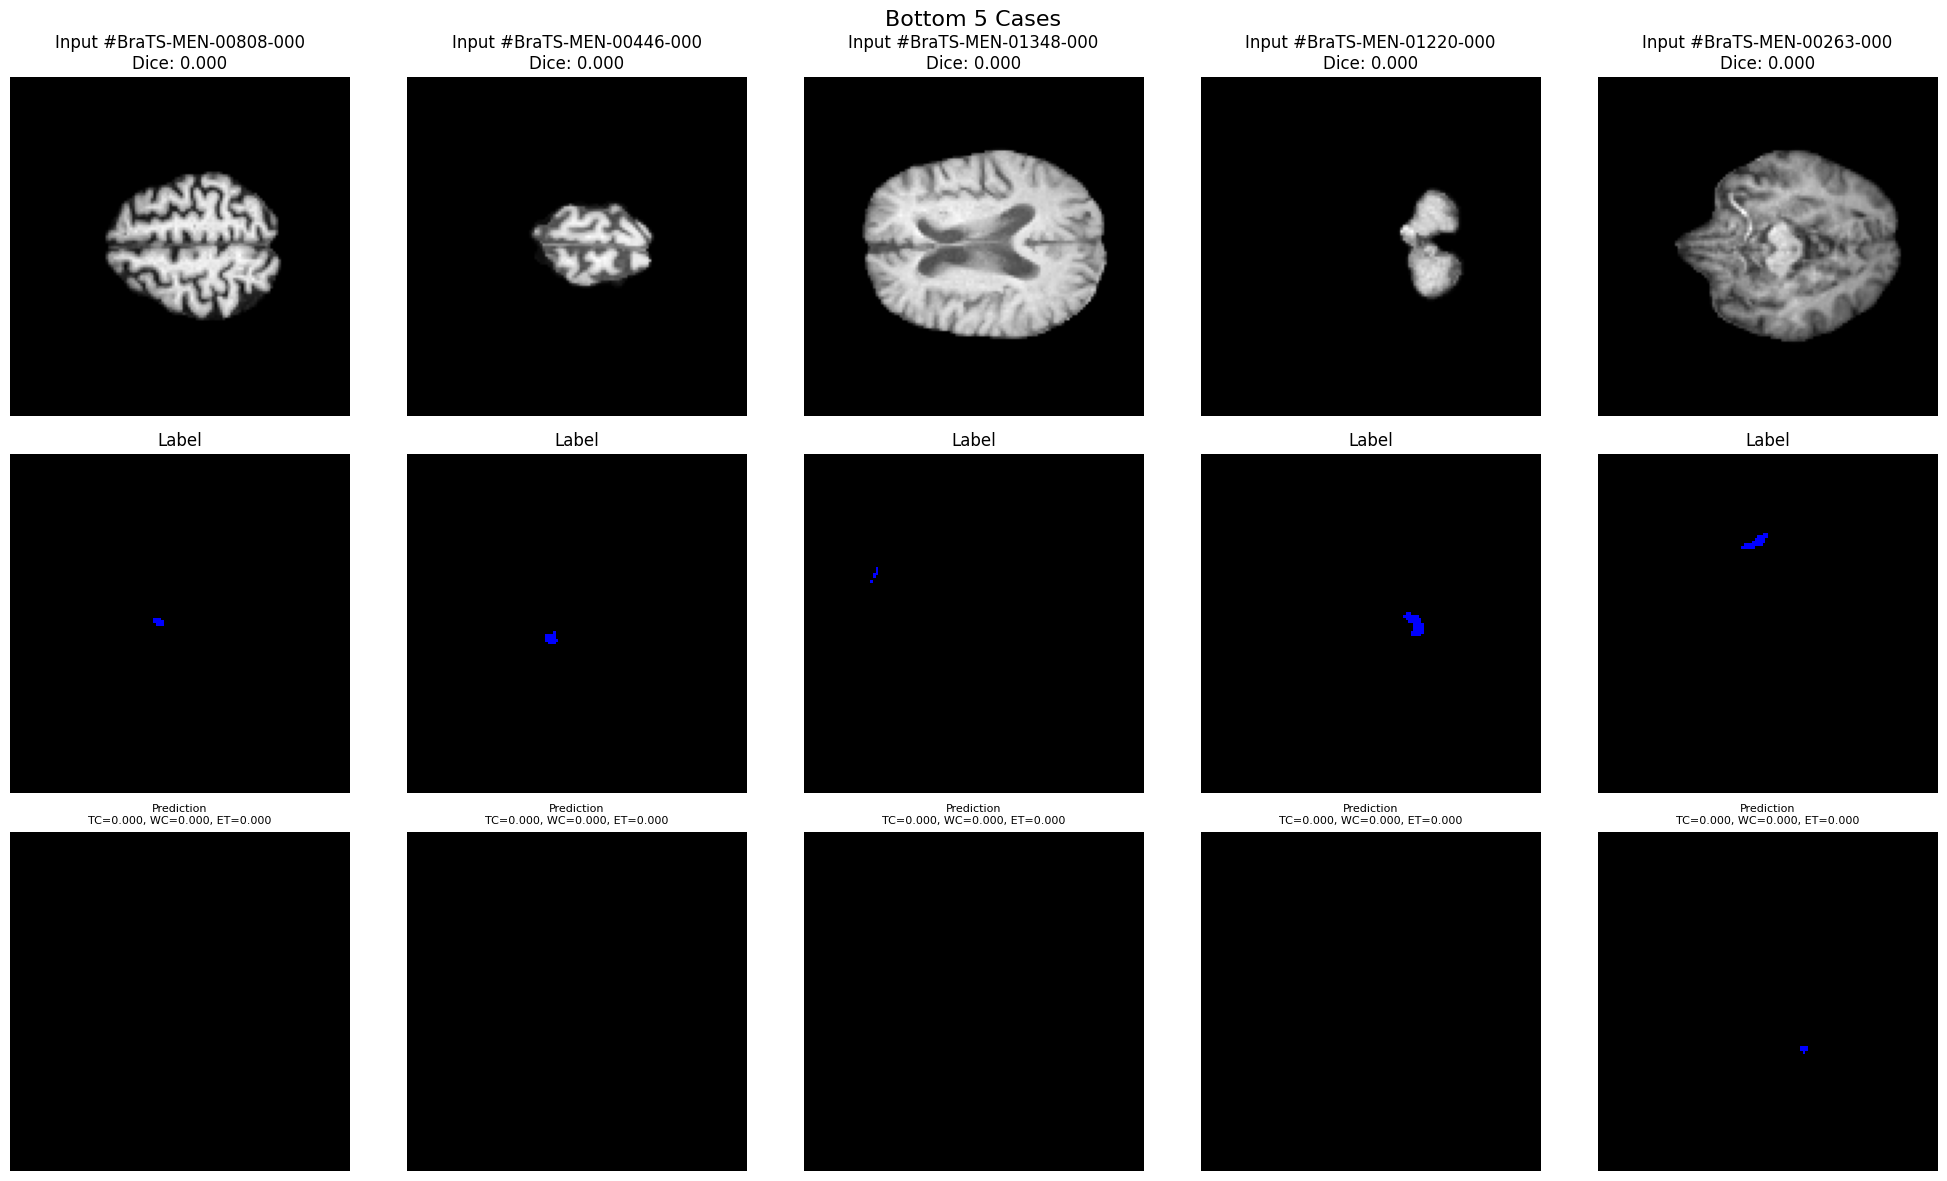

Mean Dice - TC: 0.8254, WC: 0.8193, ET: 0.8456
Mean Dice (Overall Average): 0.8301


In [7]:
# =======================================
# 1. Import
# =======================================
import os, json, math
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from monai.networks.nets import SwinUNETR

device = "cuda" if torch.cuda.is_available() else "cpu"
TARGET_SIZE = (128, 128, 128)
print("Using device:", device)

# =======================================
# 2. Utils
# =======================================
def normalize_minmax(arr, eps=1e-8):
    return (arr - arr.min()) / (arr.max() - arr.min() + eps)

def resize_3d_numpy_to_torch(arr, is_label):
    t = torch.from_numpy(arr).unsqueeze(0).unsqueeze(0).float()
    if is_label:
        t = F.interpolate(t, size=TARGET_SIZE, mode="nearest")
    else:
        t = F.interpolate(t, size=TARGET_SIZE, mode="trilinear", align_corners=False)
    return t.squeeze().cpu().numpy()

# =======================================
# 3. Fusion Head (학습과 동일)
# =======================================
class Fusion1x1(nn.Module):
    def __init__(self, in_ch=3, out_ch=4):
        super().__init__()
        self.head = nn.Conv3d(in_ch, out_ch, kernel_size=1)
    def forward(self, x):
        return self.head(x)

class FusionSmall(nn.Module):
    def __init__(self, in_ch=3, out_ch=4, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_ch, hidden, 3, padding=1),
            nn.InstanceNorm3d(hidden), nn.ReLU(inplace=True),
            nn.Conv3d(hidden, hidden, 3, padding=1),
            nn.InstanceNorm3d(hidden), nn.ReLU(inplace=True),
            nn.Conv3d(hidden, out_ch, 1)
        )
    def forward(self, x):
        return self.net(x)

# =======================================
# 4. Base SwinUNETR Loader
# =======================================
def build_swinunetr(in_channels=4):
    return SwinUNETR(
        img_size=TARGET_SIZE,
        in_channels=in_channels,
        out_channels=1,
        feature_size=48,
        use_checkpoint=True,
    )

def load_base(ckpt):
    net = build_swinunetr(4).to(device)
    sd  = torch.load(ckpt, map_location=device)
    net.load_state_dict(sd)
    net.eval()
    for p in net.parameters():
        p.requires_grad = False
    return net

# =======================================
# 5. Inference
# =======================================
@torch.no_grad()
def inference_fusion(imgs_t, gt, net_et, net_tc, net_flair, fusion):
    logit_et    = net_et(imgs_t)
    logit_tc    = net_tc(imgs_t)
    logit_flair = net_flair(imgs_t)

    feats   = torch.cat([logit_et, logit_tc, logit_flair], dim=1)
    logits4 = fusion(feats)
    pred    = torch.argmax(F.softmax(logits4, dim=1), dim=1).squeeze(0).cpu().numpy().astype(np.uint8)

    # ---------------------------
    # Hierarchical Dice 계산 (ET, TC, WC)
    # ---------------------------
    def dice_calc(mask_pred, mask_gt, eps=1e-7):
        inter = np.sum(mask_pred * mask_gt)
        union = np.sum(mask_pred) + np.sum(mask_gt)
        return (2 * inter + eps) / (union + eps) if union > 0 else np.nan

    pred_et = (pred == 3)
    pred_tc = (pred == 2) | (pred == 3)
    pred_wc = (pred >= 1)

    gt_et = (gt == 3)
    gt_tc = (gt == 2) | (gt == 3)
    gt_wc = (gt >= 1)

    dice_et = dice_calc(pred_et, gt_et)
    dice_tc = dice_calc(pred_tc, gt_tc)
    dice_wc = dice_calc(pred_wc, gt_wc)
    dice_avg = np.nanmean([dice_et, dice_tc, dice_wc])

    return pred, dice_tc, dice_wc, dice_et, dice_avg

# =======================================
# 6. Case Loader
# =======================================
def load_case(case, root_dir):
    imgs = []
    for rel_path in case["image"]:
        arr = nib.load(os.path.join(root_dir, rel_path)).get_fdata().astype(np.float32)
        arr = normalize_minmax(arr)
        arr = resize_3d_numpy_to_torch(arr, False)
        imgs.append(arr)
    imgs = np.stack(imgs, 0).astype(np.float32)
    imgs_t = torch.from_numpy(imgs).unsqueeze(0).to(device)

    gt_arr   = nib.load(os.path.join(root_dir, case["label"])).get_fdata().astype(np.uint8)
    gt_arr_rs = resize_3d_numpy_to_torch(gt_arr, True).astype(np.uint8)
    return imgs, imgs_t, gt_arr_rs

# =======================================
# 7. Visualization
# =======================================
cmap = mcolors.ListedColormap([
    (0,0,0,1),   # 0 background
    (1,0,0,1),   # 1 TC (red)
    (0,1,0,1),   # 2 FLAIR (green)
    (0,0,1,1)    # 3 ET (blue)
])
norm = mcolors.BoundaryNorm([0,1,2,3,4], cmap.N)

def show_case(imgs, gt, pred, dices, case_name, slice_idx, title_prefix="Fusion CNN"):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"{title_prefix}\nCase: {case_name}, Slice={slice_idx}", fontsize=14)

    axes[0].imshow(imgs[2, :, :, slice_idx], cmap="gray")
    axes[0].set_title("Input (T2)")
    axes[0].axis("off")

    axes[1].imshow(gt[:, :, slice_idx].astype(np.uint8), cmap=cmap, norm=norm, interpolation="nearest")
    axes[1].set_title("GT")
    axes[1].axis("off")

    dice_tc, dice_wc, dice_et, dice_avg = dices
    def fmt(x): return "N/A" if np.isnan(x) else f"{x:.3f}"

    axes[2].imshow(pred[:, :, slice_idx].astype(np.uint8), cmap=cmap, norm=norm, interpolation="nearest")
    axes[2].set_title(f"{title_prefix}\nAvg={fmt(dice_avg)}\nTC={fmt(dice_tc)}, WC={fmt(dice_wc)}, ET={fmt(dice_et)}", fontsize=10)
    axes[2].axis("off")
    plt.tight_layout()
    plt.show()

# =======================================
# 8. Run Evaluation
# =======================================
root_dir  = "C:/Users/admin/Documents/AIM_LAB/BraTS2025/BraTS-MEN-Train"
json_path = "C:/Users/admin/Documents/AIM_LAB/test_data.json"

ckpt_et    = "C:/Users/admin/Documents/AIM_LAB/output_et_1/swinunetr_et.pt"
ckpt_tc    = "C:/Users/admin/Documents/AIM_LAB/output_tc_1/swinunetr_tc.pt"
ckpt_flair = "C:/Users/admin/Documents/AIM_LAB/output_flair_1/swinunetr_flair.pt"

net_et    = load_base(ckpt_et)
net_tc    = load_base(ckpt_tc)
net_flair = load_base(ckpt_flair)

USE_SMALL = False
fusion_ckpt = "C:/Users/admin/Documents/AIM_LAB/Best_Fusion.pth"
fusion = (FusionSmall(3, 4, 16) if USE_SMALL else Fusion1x1(3, 4)).to(device)
fusion.load_state_dict(torch.load(fusion_ckpt, map_location=device))
fusion.eval()

with open(json_path) as f:
    test_data = json.load(f)["test"]

results = []
for case in test_data:
    imgs, imgs_t, gt = load_case(case, root_dir)
    pred, tc, wc, et, avg = inference_fusion(imgs_t, gt, net_et, net_tc, net_flair, fusion)
    results.append((case["label"], pred, (tc, wc, et, avg), imgs, gt))

def safe_key_avg(x):
    val = x[2][3]
    return -1 if np.isnan(val) else val

results_sorted = sorted(results, key=lambda x: safe_key_avg(x), reverse=True)

N = len(results_sorted)
top5 = results_sorted[:5]
mid5 = results_sorted[max(0, N//2 - 2): min(N, N//2 + 3)]
bot5 = results_sorted[-5:]

def show_group(group, group_name):
    n = len(group)
    if n == 0:
        print(group_name, "비어있음")
        return
    fig, axes = plt.subplots(3, n, figsize=(4*n, 12))
    fig.suptitle(f"{group_name} Cases", fontsize=16)

    if n == 1:
        axes = np.array([[axes[0]], [axes[1]], [axes[2]]])

    for i, (label_path, pred, dices, imgs, gt) in enumerate(group):
        slice_idx = int(np.argmax(gt.sum(axis=(0, 1))))
        dice_tc, dice_wc, dice_et, dice_avg = dices
        def fmt(x): return "N/A" if np.isnan(x) else f"{x:.3f}"

        axes[0, i].imshow(imgs[2, :, :, slice_idx], cmap="gray")
        axes[0, i].set_title(f"Input #{os.path.basename(os.path.dirname(label_path))}\nDice: {fmt(dice_avg)}")
        axes[0, i].axis("off")

        axes[1, i].imshow(gt[:, :, slice_idx].astype(np.uint8), cmap=cmap, norm=norm, interpolation="nearest")
        axes[1, i].set_title("Label")
        axes[1, i].axis("off")

        axes[2, i].imshow(pred[:, :, slice_idx].astype(np.uint8), cmap=cmap, norm=norm, interpolation="nearest")
        axes[2, i].set_title(f"Prediction\nTC={fmt(dice_tc)}, WC={fmt(dice_wc)}, ET={fmt(dice_et)}", fontsize=8)
        axes[2, i].axis("off")

    plt.tight_layout()
    plt.show()

show_group(top5,  "Top 5")
show_group(mid5,  "Middle 5")
show_group(bot5,  "Bottom 5")

# =======================================
# 9. Mean Dice
# =======================================
def safe_mean(values):
    valid = [v for v in values if not math.isnan(v)]
    return sum(valid) / len(valid) if valid else float("nan")

mean_tc = safe_mean([x[2][0] for x in results])
mean_wc = safe_mean([x[2][1] for x in results])
mean_et = safe_mean([x[2][2] for x in results])
mean_all = safe_mean([x[2][3] for x in results])

print(f"Mean Dice - TC: {mean_tc:.4f}, WC: {mean_wc:.4f}, ET: {mean_et:.4f}")
print(f"Mean Dice (Overall Average): {mean_all:.4f}")